In [1]:
import sys, os
import networkx as nx
import matplotlib.pyplot as plt
from stackapi import StackAPI
from bs4 import BeautifulSoup

sys.path.append(os.path.abspath("../../../src/"))
from helper.convmanager import *
from helper.stack_utils import *
from helper.utils import *

#### Utility Functions

In [2]:
site = StackAPI('stackoverflow')

questions_url = 'questions'
answers_to    = 'questions/%s/answers'
comments_to   = 'answers/%s/comments'

#### Get questions

In [3]:
site.page_size = 5     # get only 2 questions
site.max_pages = 1     # for each request (one in this case)

questions = get_questions(num_questions=5, site=site)

#### Build the graph

In [4]:
%%time

Graph = nx.DiGraph()

for question in questions['items'][3:4]:
    question_id = get_question_id(question)
    # question_sentiment = get_sentiment(get_text(question))
    Graph.add_node(question_id)
    answers = get_answers(question_id, site=site)
    
    for answer in answers['items']:
        answer_id = get_answer_id(answer)
        # answer_sentiment = get_sentiment(get_text(answer))
        similarity = get_similarity(get_text(question), get_text(answer)) # Graph.add_node(answer_id)
        # compute the weight of the edge
        Graph.add_edge(answer_id, question_id, weight=similarity)
        comments = get_comments(answer_id, site=site)
        
        for comment in comments['items']:
            comment_id = get_comment_id(comment)
            # comment_sentiment = get_sentiment(get_text(comment))
            similarity = get_similarity(get_text(answer), get_text(comment))
            # compute the weight of the edge
            Graph.add_edge(comment_id, answer_id, weight=similarity)

CPU times: user 139 ms, sys: 13.2 ms, total: 152 ms
Wall time: 3.63 s


### Draw the graph

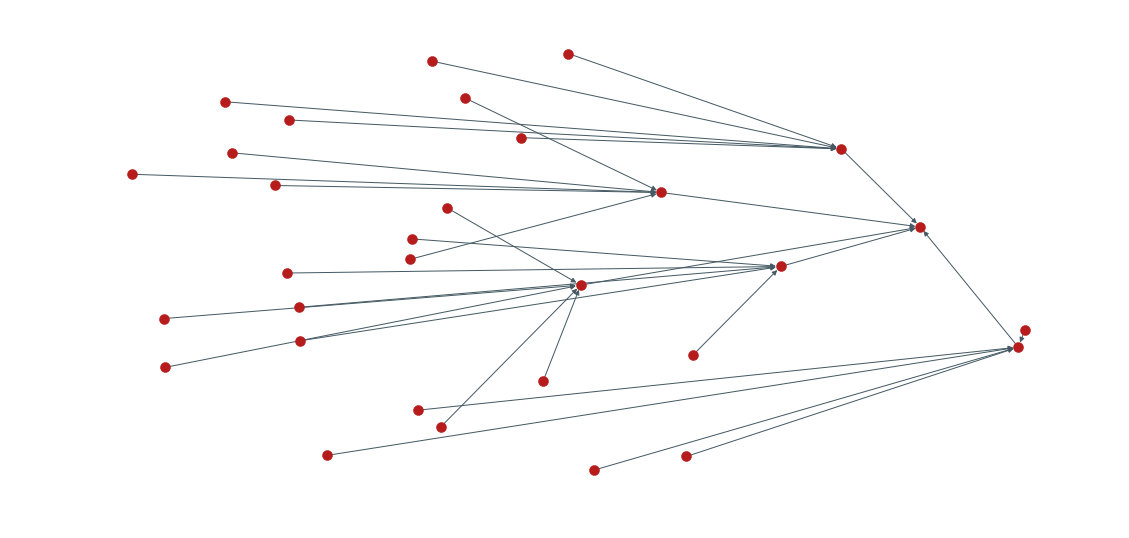

In [5]:
plt.rcParams["figure.figsize"] = [15, 7]
plt.style.use('ggplot')

pos = nx.spring_layout(Graph)
edge_labels = nx.get_edge_attributes(Graph, 'weight')

draw_options = {
    'with_labels': False,
    'node_shape' : 'o',
    'node_color' : '#B71C1C',
    'edge_color' : '#455A64',
    'node_size'  : 200,
    'width': 1
}

nx.draw(Graph, pos, **draw_options)
# nx.draw_networkx_edge_labels(Graph, pos, edge_labels=edge_labels, font_color='#006064');